## PART 1: Environment & Configuration
Description: This module establishes the runtime environment. It handles library imports and specifically configures the interface between the Python kernel and the external Tesseract-OCR binary engine. It performs a file-system check to ensure the OCR engine is accessible via the system PATH or local AppData, preventing runtime failures in downstream modules.

In [17]:
# ===============================
# CELL 1 — ENVIRONMENT & CONFIG
# ===============================

import os
import time
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# -------------------------------
# DEVICE CONFIG
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# DATASET CONFIG (LINE-LEVEL OCR)
# -------------------------------
DATASET_ROOT = "ocr_line_dataset"

IMAGE_DIR = os.path.join(DATASET_ROOT, "images")
LABEL_FILE = os.path.join(DATASET_ROOT, "labels.txt")

os.makedirs(IMAGE_DIR, exist_ok=True)

# -------------------------------
# IMAGE NORMALIZATION PARAMS
# -------------------------------
IMG_HEIGHT = 32          # fixed height
IMG_MAX_WIDTH = 512      # max width after resize


Using device: cuda


In [18]:
# ============================================================
# GLOBAL CONFIG — INPUT IMAGE
# ============================================================

IMAGE_PATH = r"F:\AneekProject\Python\Practice Python 14\Image\IMG-20251203-WA0001.jpg"

assert os.path.exists(IMAGE_PATH), f"IMAGE_PATH not found: {IMAGE_PATH}"


## PART 2: Preprocessing & Segmentation Module ("The Slicer")
Description: This function implements the primary Computer Vision pipeline. It bypasses simple global thresholding in favor of Adaptive Gaussian Thresholding, allowing the system to separate foreground text from background noise regardless of lighting gradients (shadows).

Grayscale Conversion: Reduces channel complexity.

Adaptive Thresholding: Calculates local thresholds (11x11 block size) to binarize the image.

Morphological Opening: Uses a 2x2 kernel to erode and dilate, removing high-frequency noise (dust/grain).

Contour Extraction: Utilizes RETR_EXTERNAL to retrieve external boundaries of connected components.

Geometric Filtering: Applies heuristics on Aspect Ratio (0.2 < AR < 4.0) and Bounding Box dimensions to discard non-text artifacts.

In [19]:
# ============================================================
# CELL 2 — LINE-LEVEL PREPROCESSING (CTC OCR READY)
# ============================================================
# PURPOSE:
#   - Extract full text lines (NOT characters)
#   - No slicing, no labeling, no heuristics
#   - Output is suitable for CNN → RNN → CTC OCR
#
# DEPRECATED:
#   - Character slicing
#   - Per-letter crops
#   - Manual split/merge logic
# ============================================================

import os
import cv2
import numpy as np
from PIL import Image

# ------------------------------------------------------------
# Image Loader (robust)
# ------------------------------------------------------------
def load_image(image_path_or_array):
    if isinstance(image_path_or_array, (str, os.PathLike)):
        img = cv2.imread(str(image_path_or_array))
        if img is None:
            pil = Image.open(image_path_or_array).convert("RGB")
            img = cv2.cvtColor(np.array(pil), cv2.COLOR_RGB2BGR)
    elif isinstance(image_path_or_array, np.ndarray):
        img = image_path_or_array.copy()
    else:
        raise TypeError("Input must be image path or numpy array")
    return img


# ------------------------------------------------------------
# Line Extraction (CORE FUNCTION)
# ------------------------------------------------------------
def extract_text_lines(image_path_or_array,
                       min_line_height=12,
                       max_line_height_ratio=0.35,
                       debug=False):
    """
    Adaptive line extraction for handwritten pages.
    Designed to NOT collapse page and NOT drop thin lines.
    """

    img = load_image(image_path_or_array)
    H, W = img.shape[:2]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    binary = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        15, 7
    )

    # Gentle horizontal dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 2))
    merged = cv2.dilate(binary, kernel, iterations=1)

    contours, _ = cv2.findContours(
        merged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    lines = []

    debug_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        # --- filters ---
        if h < min_line_height:
            continue
        if h > max_line_height_ratio * H:
            continue

        crop = binary[y:y+h, x:x+w]
        crop = (crop > 127).astype(np.uint8) * 255

        lines.append({
            "line_img": crop,
            "coords": (x, y, w, h)
        })

        if debug:
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    lines.sort(key=lambda l: l["coords"][1])

    if debug:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6,10))
        plt.imshow(debug_img, cmap="gray")
        plt.title(f"Detected lines: {len(lines)}")
        plt.axis("off")
        plt.show()

    return lines



# ------------------------------------------------------------
# Optional Visualization (SAFE, NO SIDE EFFECTS)
# ------------------------------------------------------------
def visualize_lines(image_path_or_array):
    img = load_image(image_path_or_array)
    lines = extract_text_lines(img)

    vis = img.copy()
    for ln in lines:
        x, y, w, h = ln["coords"]
        cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 255, 0), 2)

    return vis, lines


## PART 3: Data Acquisition & Annotation ("The Contextual Teacher")
Description: This module runs the human-in-the-loop annotation workflow. It invokes the smart_slicer to extract candidates and presents a dual-view UI using matplotlib:

Left View: The isolated, preprocessed binary crop (what the Neural Network will see).

Right View: The contextual RGB region from the original source image with a bounding box overlay (what the Human needs to identify the character). It handles directory management, creating labeled folders dynamically based on user input, and timestamps files to prevent overwriting.

[Cell 3] Detected 42 text lines


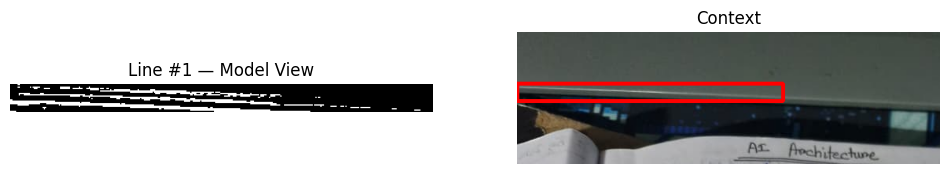

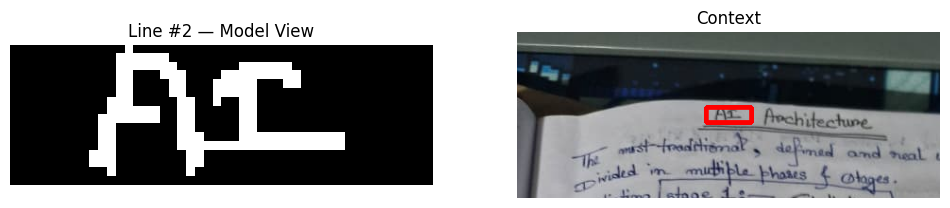

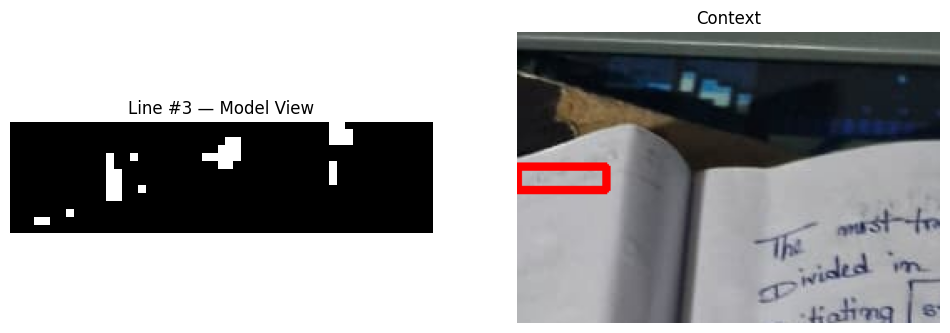

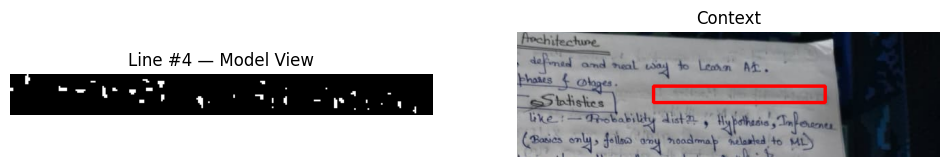

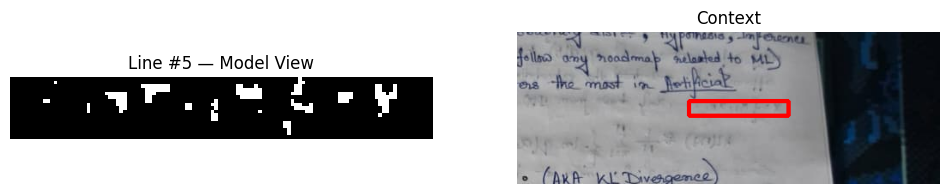

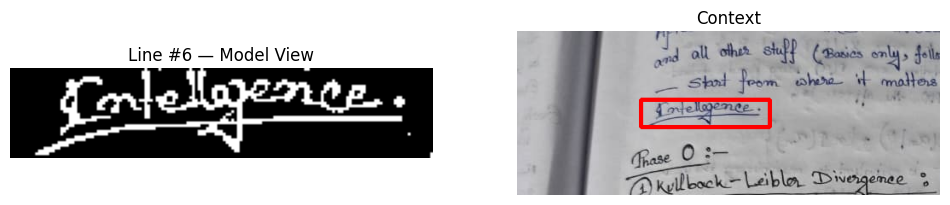

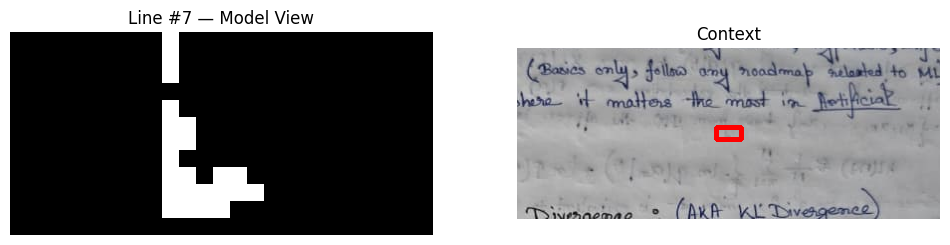

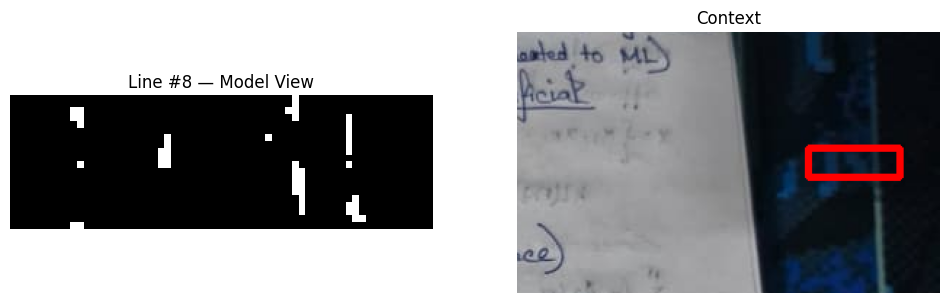

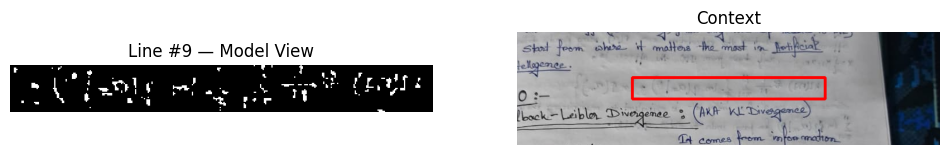

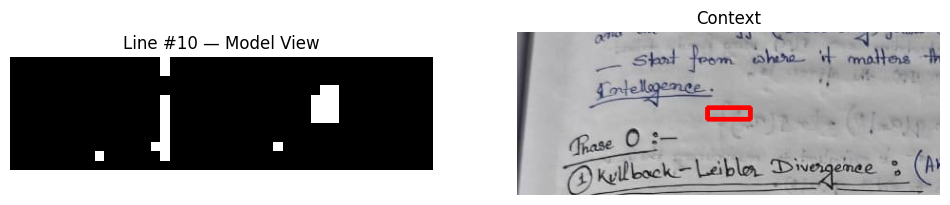

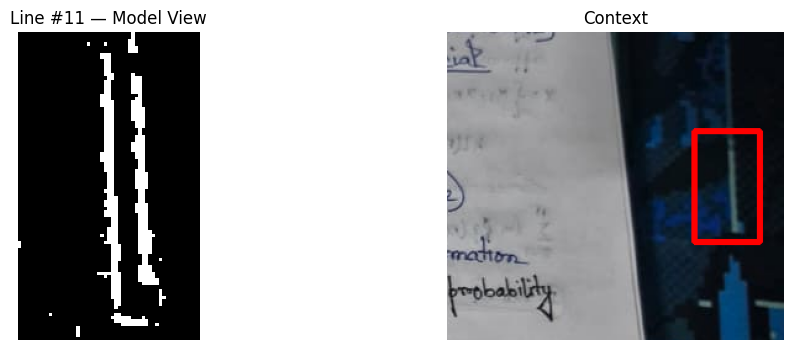

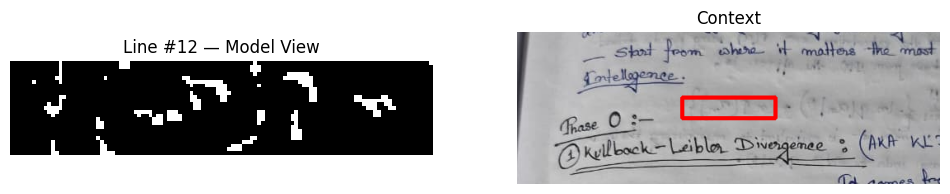

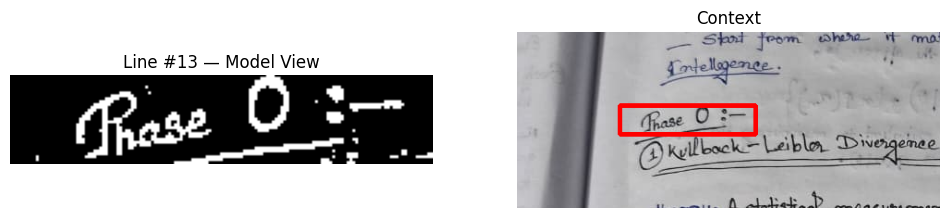

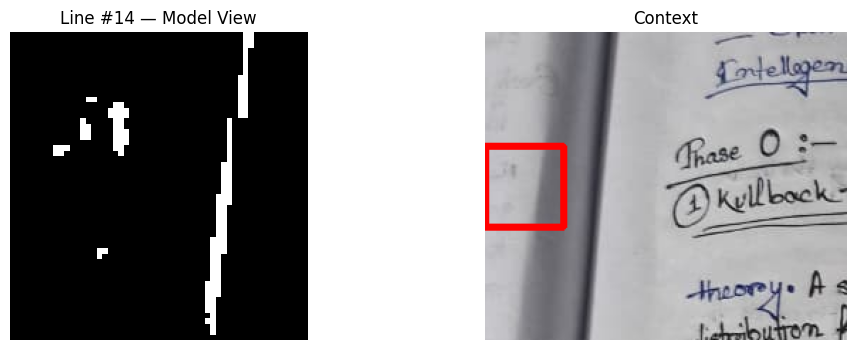

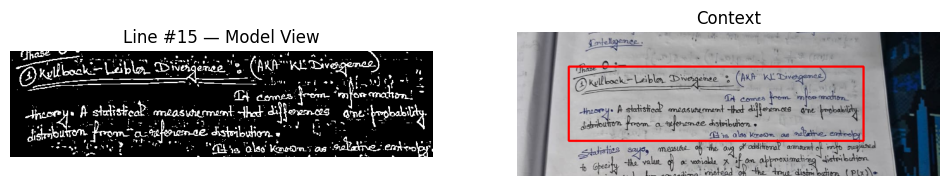

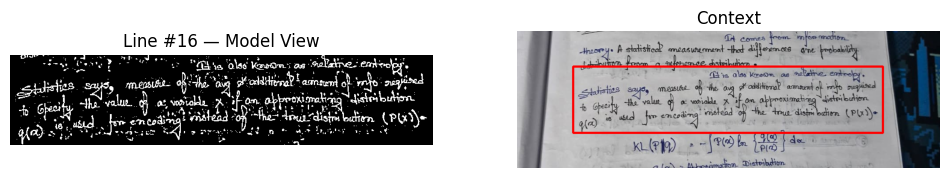

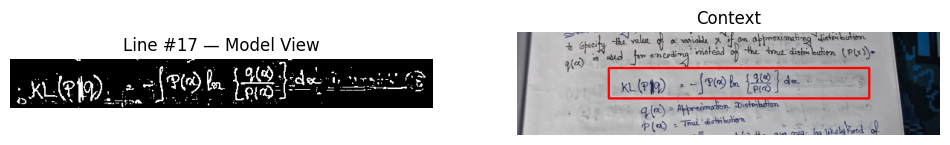

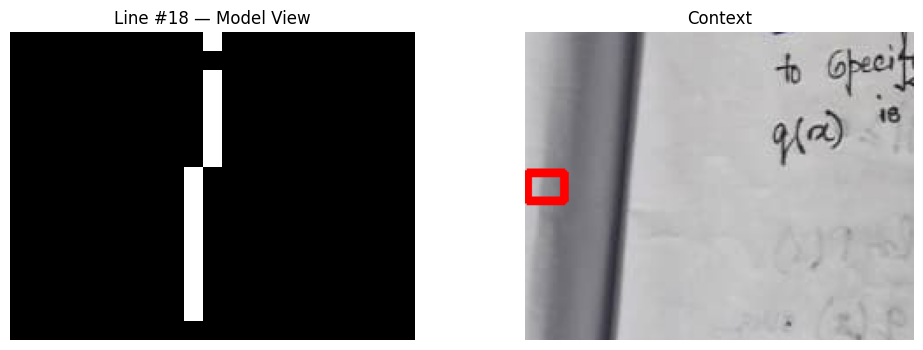

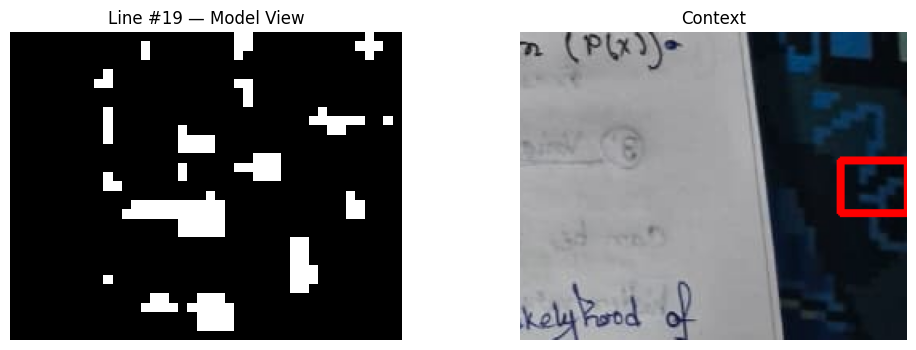

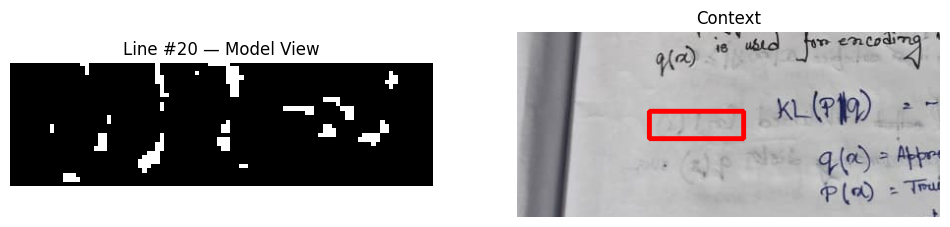

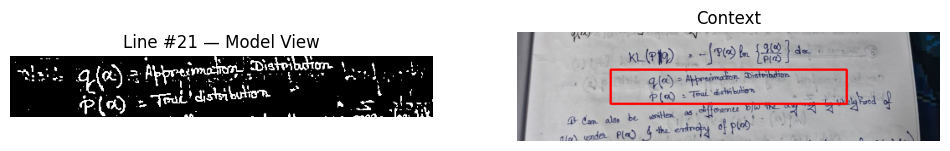

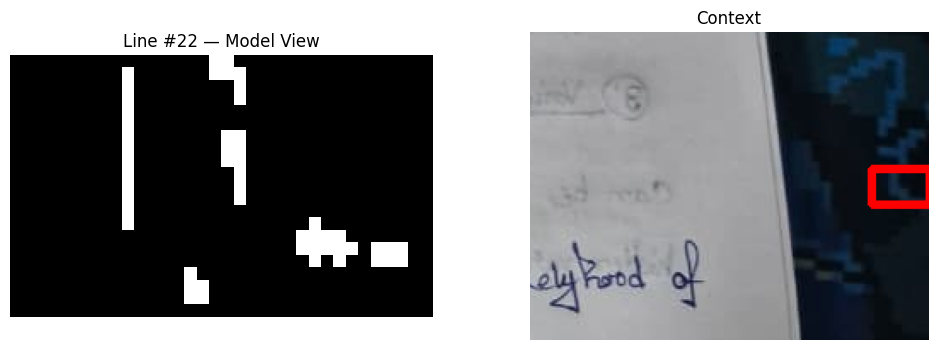

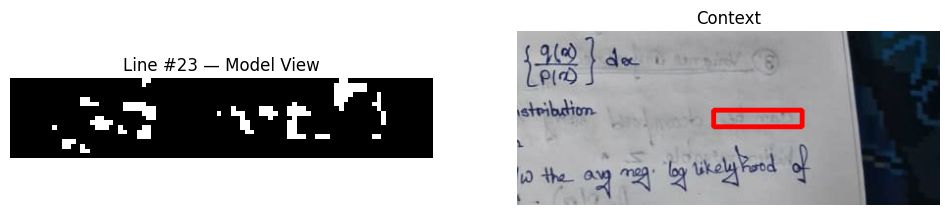

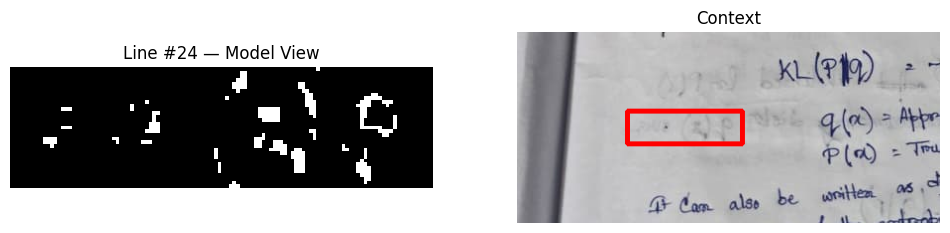

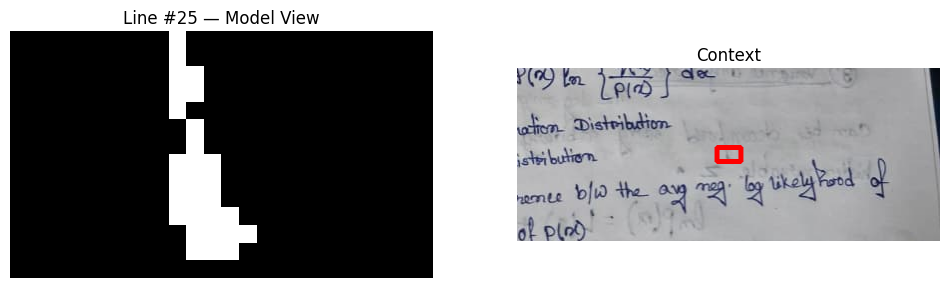

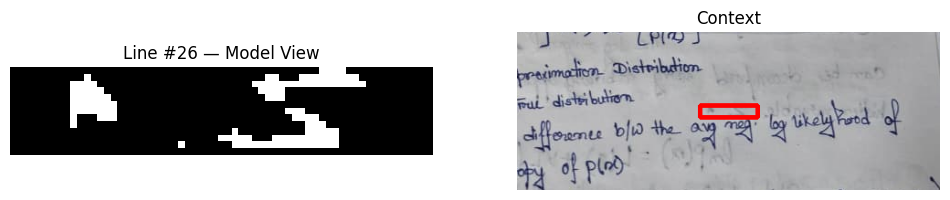

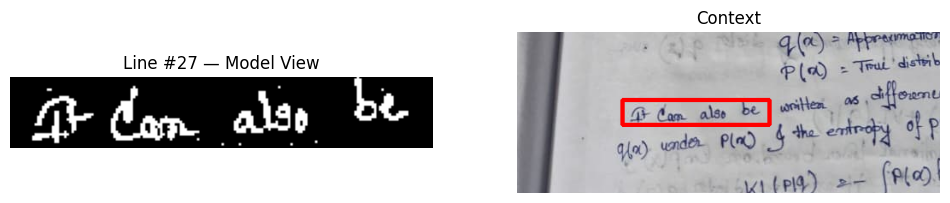

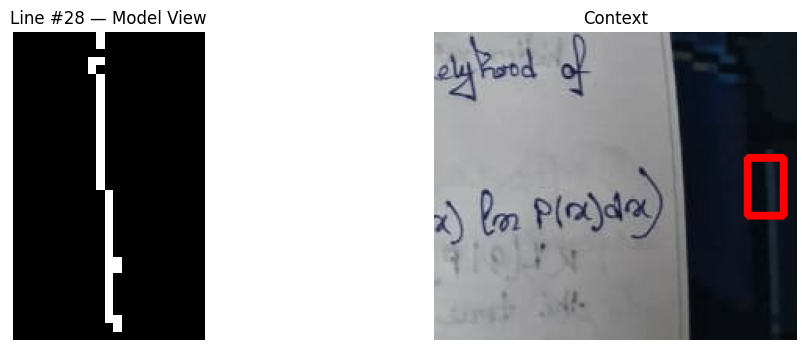

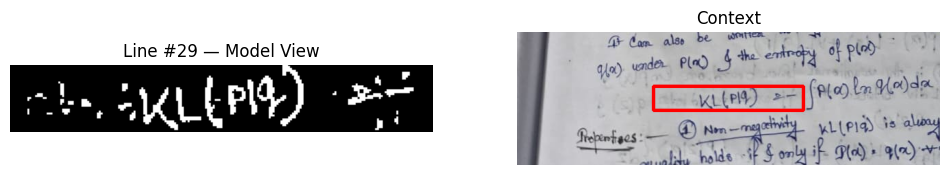

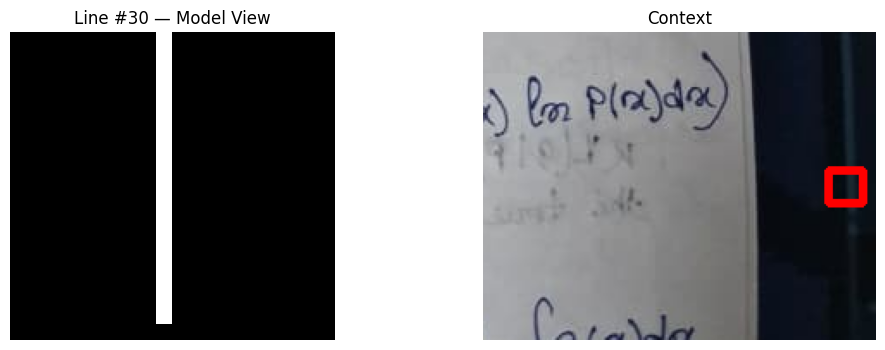

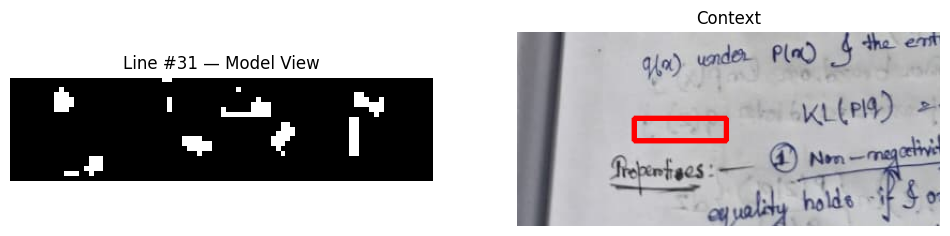

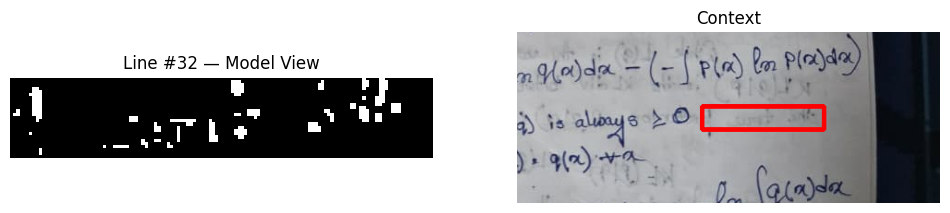

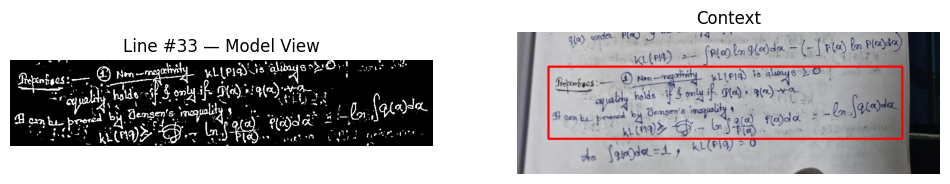

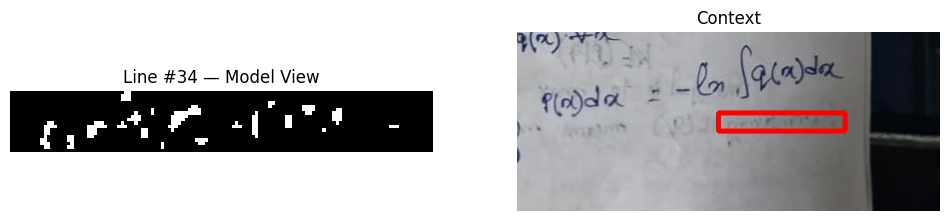

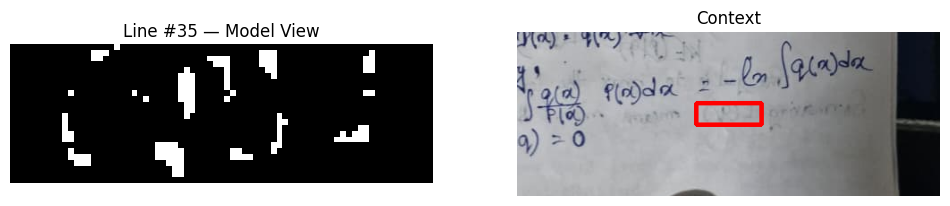

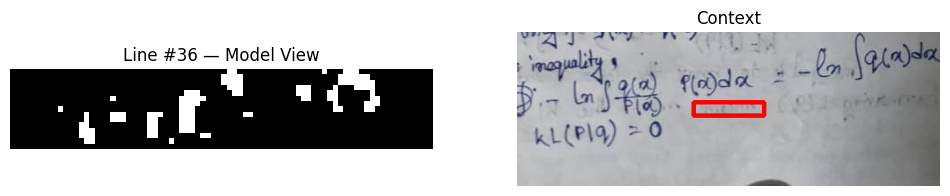

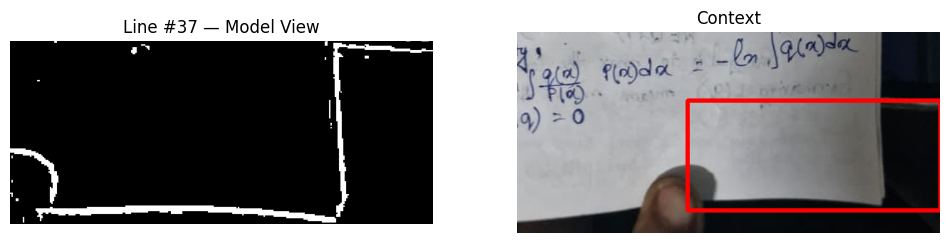

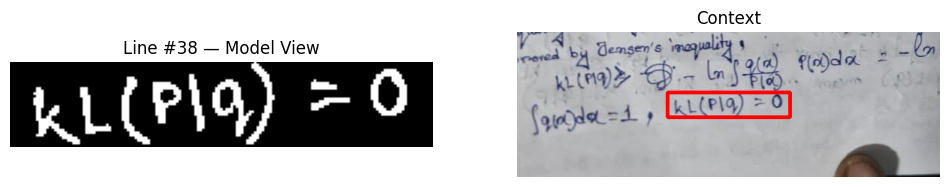

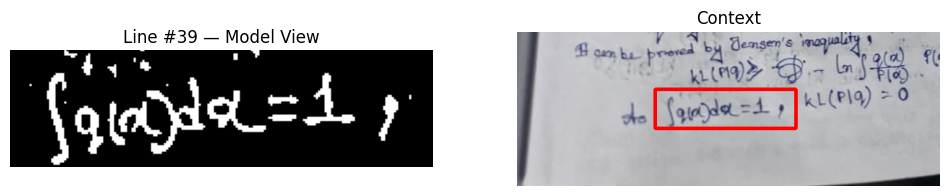

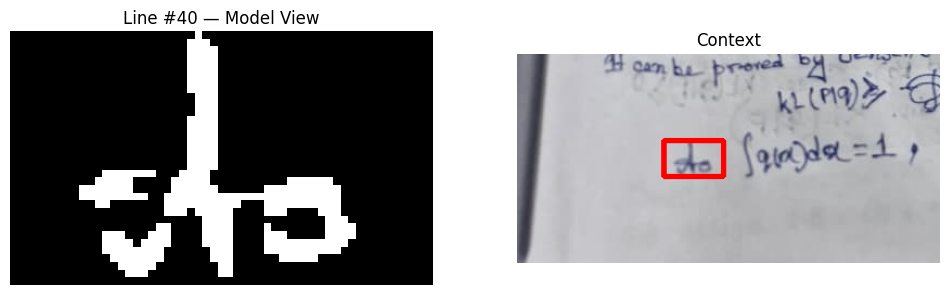

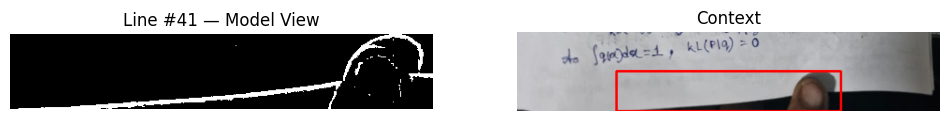

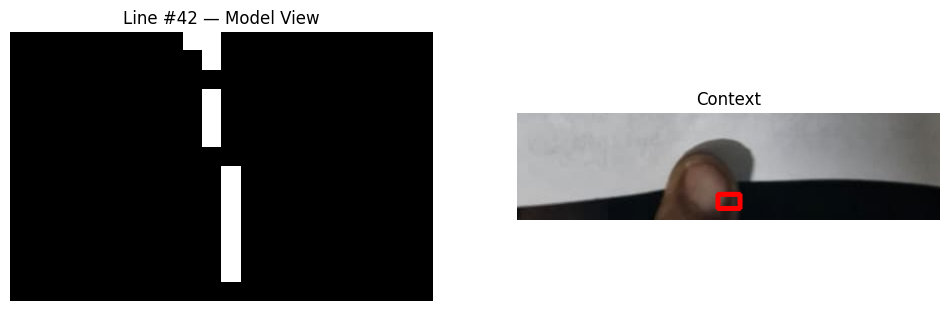

Session done. Saved=0, Skipped=42


In [20]:
# ============================================================
# CELL 3 — LINE-LEVEL DATASET BUILDER (CTC READY)
# ============================================================

import os
import cv2
import time
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

OUTPUT_ROOT = DATASET_ROOT
IMAGES_DIR = os.path.join(OUTPUT_ROOT, "images")
LABEL_FILE = os.path.join(OUTPUT_ROOT, "labels.txt")

os.makedirs(IMAGES_DIR, exist_ok=True)

def load_original_image(path):
    img = cv2.imread(path)
    if img is None:
        pil = Image.open(path).convert("RGB")
        img = cv2.cvtColor(np.array(pil), cv2.COLOR_RGB2BGR)
    return img

# ---- LOAD IMAGE USING IMAGE_PATH ----
original_bgr = load_original_image(IMAGE_PATH)
original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)

# ---- EXTRACT LINES ----
lines = extract_text_lines(IMAGE_PATH)
print(f"[Cell 3] Detected {len(lines)} text lines")

label_fh = open(LABEL_FILE, "a", encoding="utf-8")

saved = 0
skipped = 0

for i, ln in enumerate(lines):
    line_img = ln["line_img"]
    x, y, w, h = ln["coords"]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(line_img, cmap="gray")
    plt.title(f"Line #{i+1} — Model View")
    plt.axis("off")

    context = original_rgb.copy()
    cv2.rectangle(context, (x, y), (x+w, y+h), (255, 0, 0), 3)

    pad_y, pad_x = 80, 200
    y1 = max(0, y - pad_y)
    y2 = min(context.shape[0], y + h + pad_y)
    x1 = max(0, x - pad_x)
    x2 = min(context.shape[1], x + w + pad_x)

    plt.subplot(1, 2, 2)
    plt.imshow(context[y1:y2, x1:x2])
    plt.title("Context")
    plt.axis("off")

    plt.show()

    text = input("Enter full line text ('/s' skip, '/q' quit): ").strip()

    if text == "/q":
        break
    if text == "" or text == "/s":
        skipped += 1
        continue

    ts = int(time.time() * 10000)
    fname = f"line_{ts}.png"
    out_path = os.path.join(IMAGES_DIR, fname)

    # Normalize height to 32
    h0, w0 = line_img.shape
    scale = 32 / h0
    new_w = int(w0 * scale)
    resized = cv2.resize(line_img, (new_w, 32), interpolation=cv2.INTER_AREA)

    cv2.imwrite(out_path, resized)
    label_fh.write(f"{fname}|{text}\n")
    label_fh.flush()

    saved += 1
    print(f"Saved: {fname}")

label_fh.close()
print(f"Session done. Saved={saved}, Skipped={skipped}")


## PART 4: Neural Network Architecture ("The Brain")
### Description:
This class defines the Convolutional Neural Network (CNN) topology using torch.nn.Feature Extraction: Three Convolutional blocks (conv1 to conv3) with Max Pooling. This hierarchical structure extracts low-level features (edges) first, then high-level features (loops, intersections).Dimensionality Reduction: Compresses the input $32 \times 32$ image into a flat feature vector.Classification: Two Fully Connected (Dense) layers map features to the specific character classes. Includes Dropout(0.2) to regularize the model and prevent overfitting on the small dataset.

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyHandwritingNet(nn.Module):
    """
    Line-level Handwriting OCR model
    CNN → sequence → LSTM → CTC-ready output
    """

    def __init__(self, num_classes):
        super().__init__()

        # -----------------------------
        # CNN: visual feature extractor
        # -----------------------------
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),   # (B,64,H,W)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                         # ↓ H/2, W/2

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (B,128,H/2,W/2)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                         # ↓ H/4, W/4

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),                         # ↓ H/8, W/4 (keep width!)

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d((2, 1)),                         # ↓ H/16, W/4
        )

        # -----------------------------
        # RNN: reads left → right
        # -----------------------------
        self.rnn = nn.LSTM(
            input_size=512,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )

        # -----------------------------
        # Output: character probabilities
        # -----------------------------
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        """
        x: (B, 1, H, W)  ← line image
        returns:
            (B, T, num_classes)  ← per-timestep logits
        """

        if x.ndim != 4:
            raise ValueError(f"Expected 4D tensor (B,1,H,W), got {x.shape}")

        # CNN
        x = self.cnn(x)              # (B, C, H', W')

        # Collapse height → sequence over width
        x = x.mean(dim=2)            # (B, C, W')
        x = x.permute(0, 2, 1)       # (B, W', C)

        # RNN
        x, _ = self.rnn(x)           # (B, W', 512)

        # Character logits
        x = self.fc(x)               # (B, W', num_classes)

        # CTC expects log-probabilities
        return F.log_softmax(x, dim=2)


## PART 5: Logic Utilities (Reconstruction & RL)
Description: Helper functions for future inference and active learning steps:

on_user_correction: Implements the Reinforcement Learning / Active Learning feedback loop logic. It saves misclassified samples to the correct ground-truth folder to improve future training.

reconstruct_sentence: A heuristic algorithm that takes a list of spatially scattered character predictions and reconstructs the linear sentence structure. It calculates average character width to dynamically determine space thresholds.

In [22]:
# ============================================================
# CELL 5 — ONLINE LINE-LEVEL FEEDBACK & DATA AUGMENTATION
# ============================================================
# PURPOSE:
#   - Accept user correction at LINE level
#   - Store corrected samples for future fine-tuning
#   - No character logic
#   - No spacing heuristics
#   - Fully compatible with CNN → RNN → CTC OCR
# ============================================================

import os
import time
import cv2
import numpy as np

# ------------------------------------------------------------
# Save corrected LINE sample for later fine-tuning
# ------------------------------------------------------------
def on_user_line_correction(
    line_image,
    predicted_text,
    corrected_text,
    dataset_root=DATASET_ROOT
):
    """
    Stores a corrected LINE sample for future retraining.

    Args:
      line_image      : numpy array (binary or grayscale line image)
      predicted_text  : str (model output)
      corrected_text  : str (user-corrected full line)
      dataset_root    : root dataset directory

    Returns:
      message (str)
    """

    # If prediction was correct, do nothing
    if predicted_text.strip() == corrected_text.strip():
        return "Prediction confirmed. No update needed."

    # Create directories if needed
    images_dir = os.path.join(dataset_root, "images")
    labels_file = os.path.join(dataset_root, "labels.txt")

    os.makedirs(images_dir, exist_ok=True)

    # Normalize image (fixed height = 32, keep aspect ratio)
    if line_image.ndim == 3:
        line_image = cv2.cvtColor(line_image, cv2.COLOR_BGR2GRAY)

    h, w = line_image.shape
    target_h = 32
    scale = target_h / max(h, 1)
    new_w = max(1, int(w * scale))

    resized = cv2.resize(
        line_image,
        (new_w, target_h),
        interpolation=cv2.INTER_AREA
    )

    # Save image
    ts = int(time.time() * 10000)
    fname = f"line_fix_{ts}.png"
    img_path = os.path.join(images_dir, fname)
    cv2.imwrite(img_path, resized)

    # Append corrected label
    with open(labels_file, "a", encoding="utf-8") as f:
        f.write(f"{fname}|{corrected_text}\n")

    return (
        "Correction saved.\n"
        f"Old : {predicted_text}\n"
        f"New : {corrected_text}\n"
        "This sample will improve the model on next fine-tune."
    )


This cell defines the full training loop for the Personal OCR model.
It loads the labeled dataset, applies augmentations, constructs dataloaders, trains the CNN over multiple epochs, evaluates accuracy on a validation split, and finally saves both the model weights and the class-index mapping.
This training pipeline is fully synchronized with the 48×48 crop normalization done in previous cells.

Character set size (including blank): 44
Characters:  (),-.01:=ADIKLPSTabcdefghiklmnopqrstuvwxy|
Device: cuda

--- STARTING TRAINING ---
Epoch 1/40 | Loss: 17.7669
Epoch 2/40 | Loss: 4.8722
Epoch 3/40 | Loss: 4.0274
Epoch 4/40 | Loss: 2.2790
Epoch 5/40 | Loss: 3.1069
Epoch 6/40 | Loss: 2.8598
Epoch 7/40 | Loss: 2.8358
Epoch 8/40 | Loss: 2.0647
Epoch 9/40 | Loss: 2.0672
Epoch 10/40 | Loss: 2.0350
Epoch 11/40 | Loss: 2.7633
Epoch 12/40 | Loss: 2.5429
Epoch 13/40 | Loss: 2.6548
Epoch 14/40 | Loss: 1.8954
Epoch 15/40 | Loss: 2.4729
Epoch 16/40 | Loss: 2.3605
Epoch 17/40 | Loss: 2.5418
Epoch 18/40 | Loss: 1.7716
Epoch 19/40 | Loss: 1.7189
Epoch 20/40 | Loss: 1.6774
Epoch 21/40 | Loss: 2.1900
Epoch 22/40 | Loss: 2.7668
Epoch 23/40 | Loss: 2.5868
Epoch 24/40 | Loss: 2.4108
Epoch 25/40 | Loss: 2.3154
Epoch 26/40 | Loss: 1.6318
Epoch 27/40 | Loss: 1.6388
Epoch 28/40 | Loss: 2.0222
Epoch 29/40 | Loss: 1.5236
Epoch 30/40 | Loss: 1.9950
Epoch 31/40 | Loss: 1.9035
Epoch 32/40 | Loss: 1.9237
Epoch 3

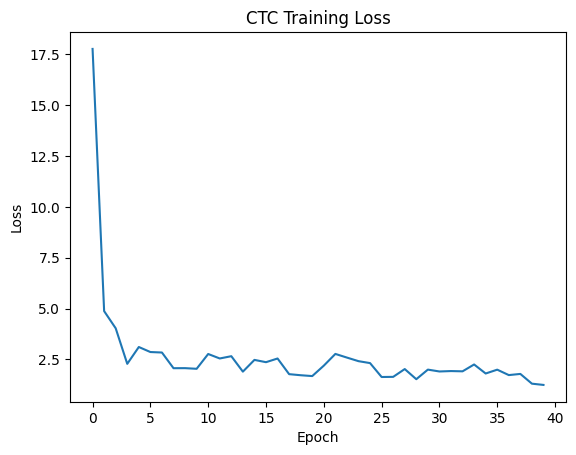

In [23]:
# ============================================================
# CELL 6 — LINE-LEVEL OCR TRAINING (CTC, AUTO CHARSET)
# ============================================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# LOAD DATA & BUILD CHARSET FROM labels.txt
# ------------------------------------------------------------
LABELS_PATH = os.path.join(DATASET_ROOT, "labels.txt")
IMAGES_DIR = os.path.join(DATASET_ROOT, "images")

assert os.path.isfile(LABELS_PATH), "labels.txt not found"
assert os.path.isdir(IMAGES_DIR), "images/ folder not found"

texts = []
with open(LABELS_PATH, "r", encoding="utf-8") as f:
    for line in f:
        _, txt = line.rstrip("\n").split("|", 1)
        texts.append(txt)

# Build charset dynamically
unique_chars = sorted(set("".join(texts)))

BLANK = "<BLANK>"
ALL_CHARS = [BLANK] + unique_chars

char2idx = {c: i for i, c in enumerate(ALL_CHARS)}
idx2char = {i: c for c, i in char2idx.items()}

print(f"Character set size (including blank): {len(ALL_CHARS)}")
print("Characters:", "".join(unique_chars))

# ------------------------------------------------------------
# DATASET
# ------------------------------------------------------------
class LineOCRDataset(Dataset):
    def __init__(self, images_dir, labels_path):
        self.images_dir = images_dir
        self.samples = []

        with open(labels_path, "r", encoding="utf-8") as f:
            for line in f:
                name, text = line.rstrip("\n").split("|", 1)
                self.samples.append((name, text))

    def encode(self, text):
        return torch.tensor(
            [char2idx[c] for c in text if c in char2idx],
            dtype=torch.long
        )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fname, text = self.samples[idx]
        img_path = os.path.join(self.images_dir, fname)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Failed to load image: {img_path}")

        img = img.astype(np.float32) / 255.0
        img = torch.from_numpy(img).unsqueeze(0)  # (1, H, W)

        label = self.encode(text)
        return img, label, len(label)

# ------------------------------------------------------------
# COLLATE FUNCTION (PAD WIDTH FOR CTC)
# ------------------------------------------------------------
def ctc_collate(batch):
    images, labels, label_lengths = zip(*batch)

    widths = [img.shape[-1] for img in images]
    max_w = max(widths)

    padded_images = []
    for img in images:
        pad = max_w - img.shape[-1]
        padded_images.append(
            nn.functional.pad(img, (0, pad))
        )

    images = torch.stack(padded_images)
    labels = torch.cat(labels)
    label_lengths = torch.tensor(label_lengths, dtype=torch.long)

    return images, labels, label_lengths

# ------------------------------------------------------------
# TRAINING SETUP
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

dataset = LineOCRDataset(IMAGES_DIR, LABELS_PATH)
loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=ctc_collate
)

model = MyHandwritingNet(num_classes=len(ALL_CHARS)).to(device)
criterion = nn.CTCLoss(blank=char2idx[BLANK], zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ------------------------------------------------------------
# TRAIN LOOP
# ------------------------------------------------------------
EPOCHS = 40
loss_history = []

print("\n--- STARTING TRAINING ---")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    for images, labels, label_lengths in loader:
        images = images.to(device)
        labels = labels.to(device)
        label_lengths = label_lengths.to(device)

        outputs = model(images)          # (B, T, C)
        outputs = outputs.permute(1, 0, 2)  # (T, B, C)

        input_lengths = torch.full(
            size=(outputs.size(1),),
            fill_value=outputs.size(0),
            dtype=torch.long,
            device=device
        )

        loss = criterion(outputs, labels, input_lengths, label_lengths)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f}")

# ------------------------------------------------------------
# SAVE MODEL + CHARSET
# ------------------------------------------------------------
torch.save(
    {
        "model_state": model.state_dict(),
        "char2idx": char2idx,
        "idx2char": idx2char
    },
    "ocr_line_ctc.pth"
)

print("\nSaved model + charset → ocr_line_ctc.pth")

# ------------------------------------------------------------
# LOSS CURVE
# ------------------------------------------------------------
plt.plot(loss_history)
plt.title("CTC Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


## Judgement Playground


Dont change the line pr code or anything from here, untill u change the whole version of this OCR. 

In [33]:
# ============================================================
# CELL 7 — FINAL OCR INFERENCE (ROBUST & CONSISTENT)
# ============================================================

import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# LOAD MODEL + CHARSET
# ----------------------------
checkpoint = torch.load("ocr_line_ctc.pth", map_location="cpu")

char2idx = checkpoint["char2idx"]
idx2char = checkpoint["idx2char"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyHandwritingNet(num_classes=len(char2idx))
model.load_state_dict(checkpoint["model_state"])
model.to(device)
model.eval()

BLANK_IDX = char2idx["<BLANK>"]

# ----------------------------
# CTC GREEDY DECODER
# ----------------------------
def ctc_greedy_decode(log_probs):
    preds = log_probs.argmax(dim=1).cpu().numpy()
    out = []
    prev = None
    for p in preds:
        if p != prev and p != BLANK_IDX:
            out.append(idx2char[p])
        prev = p
    return "".join(out)

# ----------------------------
# LINE NORMALIZATION (CRITICAL)
# ----------------------------
def normalize_line_for_ocr(img):
    """
    Forces inference lines to match training distribution.
    """

    # Ensure grayscale
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 1. Binarize
    _, img = cv2.threshold(
        img, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # 2. Ensure white text on black background
    if np.mean(img) > 127:
        img = 255 - img

    # 3. Remove small noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    # 4. Reject almost-empty lines
    ink_ratio = np.sum(img > 0) / img.size
    if ink_ratio < 0.01:
        return None

    return img

# ----------------------------
# RUN OCR ON IMAGE
# ----------------------------
TEST_IMAGE_PATH = r"Image/IMG-20251203-WA0001.jpg"  # CHANGE IF NEEDED
assert os.path.isfile(TEST_IMAGE_PATH), "Test image not found"

lines = extract_text_lines(TEST_IMAGE_PATH)
print(f"\nDetected {len(lines)} candidate lines\n")

results = []

for i, ln in enumerate(lines):
    img = ln.get("crop", None)
    if img is None:
        continue

    img = normalize_line_for_ocr(img)
    if img is None:
        continue

    # Resize to fixed height (same as training)
    h, w = img.shape
    scale = 32 / h
    new_w = max(1, int(w * scale))
    img = cv2.resize(img, (new_w, 32), interpolation=cv2.INTER_AREA)

    # Convert to tensor
    tensor = torch.from_numpy(img).float().unsqueeze(0).unsqueeze(0) / 255.0
    tensor = tensor.to(device)

    with torch.no_grad():
        out = model(tensor).squeeze(0)  # (T, C)
        text = ctc_greedy_decode(out)

    results.append(text)
    print(f"[Line {i+1}] → {text}")

# ----------------------------
# FINAL OUTPUT
# ----------------------------
print("\n--- FULL OCR OUTPUT ---\n")
print("\n".join(results))



Detected 42 candidate lines


--- FULL OCR OUTPUT ---




C:\Users\ANEEK SARKAR\AppData\Local\Temp\ipykernel_21660\1075010734.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("ocr_line_ctc.pth", map_loca

Detected 79 lines


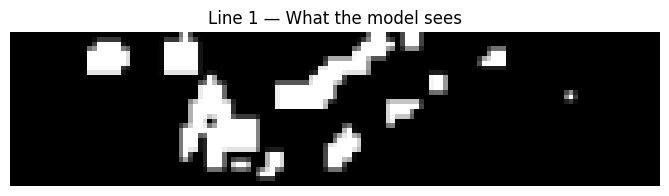

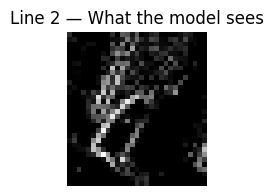

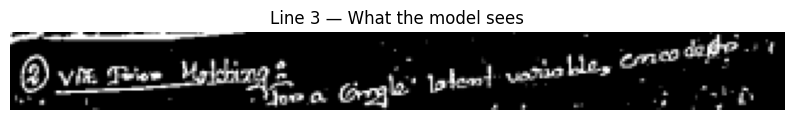

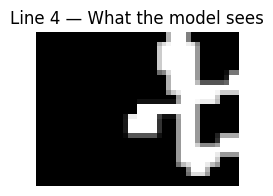

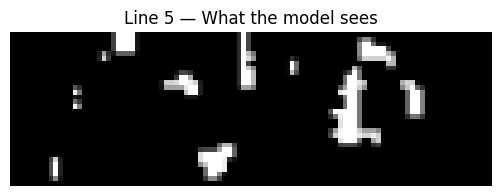

In [32]:
## Debug cell

import matplotlib.pyplot as plt
import cv2

TEST_IMAGE_PATH = r"Image/IMG-20251203-WA0004.jpg"

lines = extract_text_lines(TEST_IMAGE_PATH)

print(f"Detected {len(lines)} lines")

for i, ln in enumerate(lines[:5]):  # first 5 only
    if "crop" in ln:
        img = ln["crop"]
    elif "line_img" in ln:
        img = ln["line_img"]
    else:
        continue

    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # resize exactly like inference
    h, w = img.shape
    scale = 32 / h
    new_w = max(1, int(w * scale))
    img = cv2.resize(img, (new_w, 32), interpolation=cv2.INTER_AREA)

    plt.figure(figsize=(10,2))
    plt.imshow(img, cmap="gray")
    plt.title(f"Line {i+1} — What the model sees")
    plt.axis("off")
    plt.show()


In [28]:
# This cell is NOT about fake accuracy numbers.
# It helps you judge OCR quality honestly.

from difflib import SequenceMatcher

def character_error_rate(pred, truth):
    """
    CER = edit_distance / len(truth)
    """
    matcher = SequenceMatcher(None, pred, truth)
    edits = sum(triple.size for triple in matcher.get_opcodes()
                if triple.tag != 'equal')
    return edits / max(1, len(truth))


# ----------------------------
# MANUAL EVALUATION
# ----------------------------
print("PASTE the ground-truth text for comparison.")
print("Leave empty to skip CER calculation.\n")

ground_truth = input("Ground truth text:\n").strip()

predicted_text = "\n".join(results)

print("\n--- PREDICTED TEXT ---\n")
print(predicted_text)

if ground_truth:
    cer = character_error_rate(predicted_text, ground_truth)
    print(f"\nCharacter Error Rate (CER): {cer:.3f}")
else:
    print("\nCER skipped (no ground truth provided).")


# ----------------------------
# HOW TO INTERPRET THIS
# ----------------------------
print("""
HOW TO JUDGE RESULT (IMPORTANT):

CER ~ 0.1–0.3  → Very good for handwritten OCR
CER ~ 0.3–0.5  → Readable, needs more data
CER > 0.5      → Too noisy, add cleaner samples

But CER is secondary.

Primary question:
👉 Can YOU read the output without seeing the image?

If yes → system works.
If no  → add more labeled lines.
""")


PASTE the ground-truth text for comparison.
Leave empty to skip CER calculation.


--- PREDICTED TEXT ---












































CER skipped (no ground truth provided).

HOW TO JUDGE RESULT (IMPORTANT):

CER ~ 0.1–0.3  → Very good for handwritten OCR
CER ~ 0.3–0.5  → Readable, needs more data
CER > 0.5      → Too noisy, add cleaner samples

But CER is secondary.

Primary question:
👉 Can YOU read the output without seeing the image?

If yes → system works.
If no  → add more labeled lines.

